# $\phi_1 = \frac{I\rho}{4\pi R} + \sum_{n=0}^{\infty} A_n r^{-(n+1)}P_n (cos\theta)$

# $\phi_1 = \sum_{n=0}^{\infty} B_n r^n P_n (cos\theta)$

In [151]:
import numpy as np
from scipy import special
from SimPEG import Mesh

In [197]:
hx = np.ones(101)*1.
hz = np.ones(50)*1.
mesh = Mesh.TensorMesh([hx, hx, np.r_[0.]], "CCC")

In [198]:
print mesh

  ---- 3-D TensorMesh ----  
   x0: -50.50
   y0: -50.50
   z0: -0.00
  nCx: 101
  nCy: 101
  nCz: 1
   hx: 101*1.00
   hy: 101*1.00
   hz: 0.00


In [199]:
r = np.sqrt((mesh.gridCC**2).sum(axis=1))
radius = 10.
sphind  = r <radius
sigma = np.ones(mesh.nC)*1e-3
sigma[sphind] = 1e-8

In [202]:
# mesh.plotSlice(np.log10(sigma), normal='Z', ind=49)

In [203]:
# mesh.plotSlice(np.log10(sigma), normal='Y', ind=49)

In [204]:
%matplotlib inline
import matplotlib.pyplot as plt

In [205]:
p = special.legendre(1, monic=0)

In [206]:
deg2rad  = lambda deg: deg/180.*np.pi
rad2deg  = lambda rad: rad*180./np.pi

In [248]:
Pleg = []
for i in range(20):
    Pleg.append(special.legendre(i, monic=0))

In [249]:
txloc = np.r_[-60., 0., 0.]
# Assume center of the sphere is the origin
r = np.sqrt((mesh.gridCC**2).sum(axis=1))
r[r<1e-10] = 1e-1
costheta = mesh.gridCC[:,0]/r
R = (r**2+txloc[0]**2.-2.*r*txloc[0]*costheta)**0.5
radius = 10.
sphind = r <= radius
temp = np.zeros_like(r)

In [532]:
def AnBnfun(n, radius, x0, rho, rho1, I=1.):
    const = I*rho/(4*np.pi)
    bunmo = n*rho + (n+1)*rho1
    An = const * radius**(2*n+1) / x0 ** (n+1.) * n * (rho1-rho) / bunmo
    Bn = const * 1. / x0 ** (n+1.) * (2*n+1) * (rho1) / bunmo
    return An, Bn

In [524]:
test = np.zeros((len(Pleg), temp.size))
rho, rho1 = 100., 1e3
prim = rho*1./(4*np.pi*R)
flag = "sec"
for n in range(len(Pleg)):
    An, Bn = AnBnfun(n, radius, txloc[0], rho, rho1)
    dumout = An*r[~sphind]**(-n-1)*Pleg[n](costheta[~sphind])
    test[n, ~sphind] = dumout
    dumin = Bn*r[sphind]**(n)*Pleg[n](costheta[sphind])
    test[n, sphind] = dumin

<matplotlib.colorbar.Colorbar instance at 0x111874fc8>

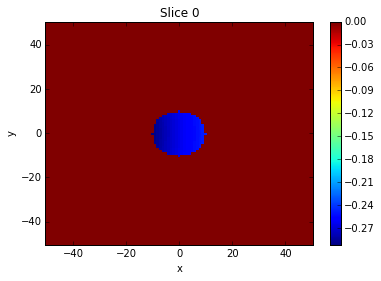

In [540]:
n=0
An, Bn = AnBnfun(n, radius, txloc[0], rho, rho1)
dumout = An*r[~sphind]**(-n-1)*Pleg[n](costheta[~sphind])
dumin = Bn*r[sphind]**(n)*Pleg[n](costheta[sphind])
if n ==0:
    temp[sphind] = dumin-prim[sphind]
temp[~sphind] = dumout
dat = mesh.plotSlice(temp)
plt.colorbar(dat[0])

In [525]:
# flag = "sec"
# out = temp.copy()
# for n in range(20):
#     An, Bn = AnBnfun(n, radius, txloc[0], rho, rho1)
#     dumout = An*r[~sphind]**(-n-1.)*Pleg[n](costheta[~sphind])
#     out[~sphind] += dumout
#     dumin = Bn*r[sphind]**(n)*Pleg[n](costheta[sphind])    
#     out[sphind] += dumin
    
# if flag == "total":
#     out += prim


In [526]:
# # flag = "sec"
# def fields(txloc, radius, rho, rho1, flag = "sec"):
# # def fields(txloc, radius, rho, rho1, flag = "sec"):
#     """
#         Parameters:
#             txloc:
#             radius:
#             rho:
#             rho1:
#             flag:

#     """
#     out = np.zeros_like(r)
#     prim = rho*1./(4*np.pi*R)
#     for n in range(10):
#         An, Bn = AnBnfun(n, 2*radius, txloc[0], rho, rho1)
#         dumout = An*r[~sphind]**(-n-1)*Pleg[n](costheta[~sphind])
#         out[~sphind] += dumout
#         dumin = Bn*r[sphind]**(n)*Pleg[n](costheta[sphind])    
#         out[sphind] += dumin

#     if flag == "sec":
#         out[sphind] = dumin 
#     elif flag == "total":
#         out[sphind] += prim[sphind]
#         out[~sphind] += prim[~sphind]
#     return out

In [527]:
from ipywidgets import interact, IntSlider

In [528]:
def ordertest(n):
    dat = mesh.plotSlice(test[:n, :].sum(axis=0))
#     dat = mesh.plotSlice(prim)    
    plt.colorbar(dat[0])

In [529]:
# mesh.setCellGradBC("neumann")
# G = mesh.cellGrad

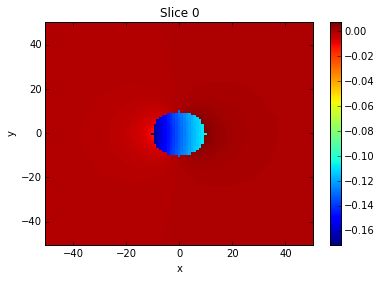

In [530]:
interact(ordertest, n=IntSlider(min = 0, max = 30, step = 1, value = 0.))

In [404]:
# phi = fields(txloc, radius, rho, rho1, flag = "sec")

In [405]:
# e = -G*out

<matplotlib.colorbar.Colorbar instance at 0x1114651b8>

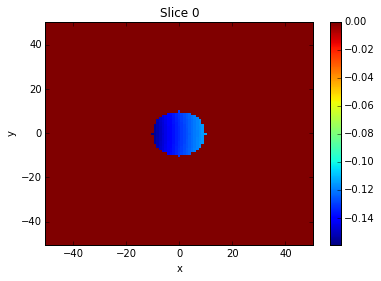

In [406]:
dat = mesh.plotSlice(out)
plt.colorbar(dat[0])

In [176]:
sigma = 1./rho*np.ones(mesh.nC)
sigma[sphind] = 1./rho1
MfSig = mesh.getFaceInnerProduct(sigma)

In [177]:
Mfinv = mesh.getFaceInnerProduct(invMat=True, doFast=True)

In [178]:
j = Mfinv*MfSig*e

ValueError: dimension mismatch

In [179]:
def slicer(i):
    dat = mesh.plotSlice(e, vType="F", ind=i, view='vec', streamOpts={'color':'w'})
    plt.colorbar(dat[0])
    return 

In [180]:
interact(slicer, i=IntSlider(min = 0, max = 99, step = 1, value = 50))

AssertionError: Vector is not the right size.

<function __main__.slicer>

In [181]:
dat = mesh.plotSlice(j, vType="F", ind=50, view='vec', streamOpts={'color':'w'})
plt.colorbar(dat[0])

NameError: name 'j' is not defined